In [1]:
import sys
import os
import glob
sys.path.append('../..')

from model import processing

prefix = 'FTTBUSD'
tick = '1s'

path = 'input/'
extension = 'csv'
os.chdir(path)
result = glob.glob(prefix + '-' + tick + '-' + '*.{}'.format(extension))
os.chdir('..')

# input_filename = 'input/DOTBUSD-1s-2022-11-22.csv'
print(result)
# input_filename = 'input/test.csv'
output_filename = 'output/' + prefix + "-" + tick + "-output.csv"

price_data = processing.import_binance_prices(path, result)[::6]
# price_data2 = processing.de_freq(price_data, 180)
# price_list = [None]*len(price_data)
final_price = price_data[-1]
price_data.extend([final_price] * 1000)
price_list = [{'DOT':data.price} for data in price_data]
print(price_list[0:10])

['FTTBUSD-1s-2022-11-07.csv', 'FTTBUSD-1s-2022-11-08.csv', 'FTTBUSD-1s-2022-11-09.csv']
[{'DOT': 22.26}, {'DOT': 22.26}, {'DOT': 22.26}, {'DOT': 22.25}, {'DOT': 22.27}, {'DOT': 22.27}, {'DOT': 22.27}, {'DOT': 22.27}, {'DOT': 22.29}, {'DOT': 22.29}]


In [2]:
from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, dynamic_fee
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)

price_dict = {
    'HDX': 0.05,
    'USD': 1,
    'LRNA': 0.5,
    'R1': 2,
    'R2': 2/3,
    'DOT': price_list[0]['DOT']
}

def lrna_price(asset: str):
    return price_dict[asset] / price_dict['LRNA'] 

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                'HDX': {'liquidity': 1000000, 'LRNA_price': lrna_price('HDX')},
                'USD': {'liquidity': 1000000, 'LRNA_price': lrna_price('USD')},
                'R1': {'liquidity': 1000000, 'LRNA_price': lrna_price('R1')},
                'R2': {'liquidity': 3000000, 'LRNA_price': lrna_price('R2')},
                'DOT': {'liquidity': 1000000, 'LRNA_price': lrna_price('DOT')}
            },
            lrna_fee=0.0005,
            oracles={'fee_raise': 50, 'fee_lower': 7200},
            asset_fee=dynamic_fee(0.0025, 0.0005, 1000000, 'fee_raise', 'fee_lower'),
        )
    },
    agents = {
        'Arbitrageur': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool'
            )
        ),
        'LPDOT': Agent(
            holdings={'DOT': 500000},
            trade_strategy=invest_all('omnipool')
        ),
    },
    evolve_function=historical_prices(price_list),
    external_market=price_dict
)
print(len(price_list))
time_steps = len(price_list)-1
events = run.run(initial_state, time_steps=time_steps)

events = processing.postprocessing(events, optional_params=['withdraw_val'])

pprint(events[-1])

44167
Starting simulation...
Execution time: 85.014 seconds.
{'state': global state 
pools: 

    Omnipool: omnipool
    ********************************
    tvl cap: inf
    lrna fee: 0.05%
    asset fee: Dynamic fee (oracle=fee_raise, decay=0.0005, amplification=1000000, min=0.0025)
    asset pools: (
    
        *HDX*
        asset quantity: 449484.6053065211
        lrna quantity: 249779.02420626805
        USD price: 0.55570095451
        tvl: $22474.230265326056
        weight: 249779.02420626805/76442947.30389011 (0.0032675221588893007)
        weight cap: 1.0
        total shares: 1000000.0
        protocol shares: 1000000.0
    
        *USD*
        asset quantity: 449496.98855862144
        lrna quantity: 4995718.111825602
        USD price: 11.114019090195
        tvl: $449496.98855862144
        weight: 4995718.111825602/76442947.30389011 (0.06535224357540405)
        weight cap: 1.0
        total shares: 1000000.0
        protocol shares: 1000000.0
    
        *R1*
    

<AxesSubplot:title={'center':'asset price: R2 '}>

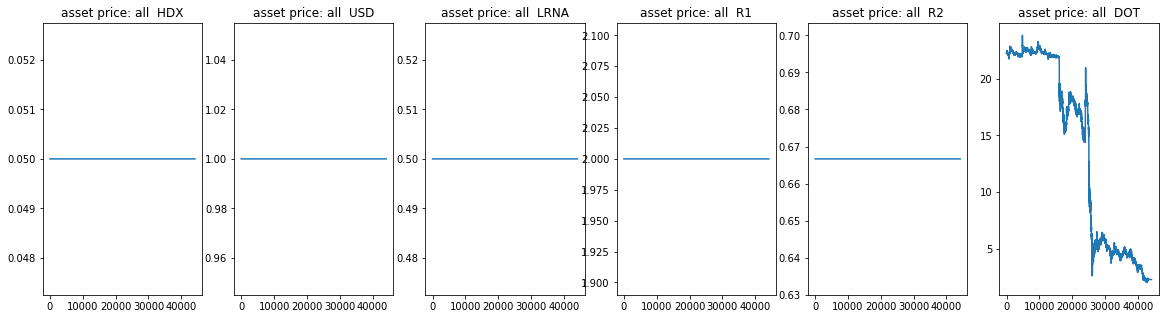

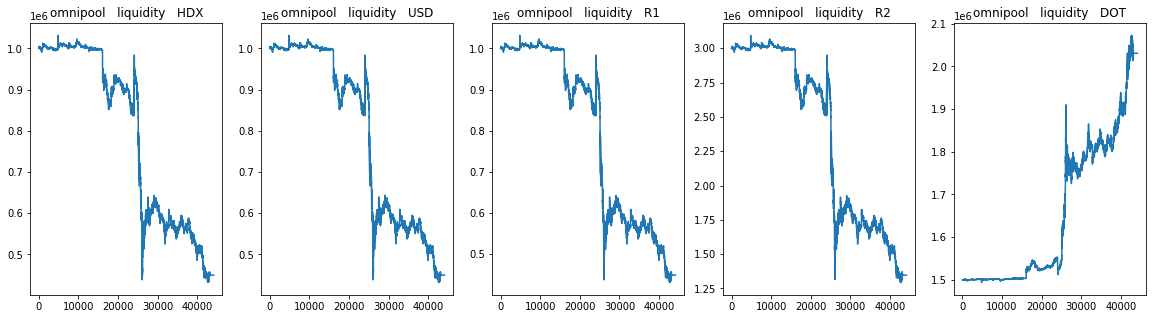

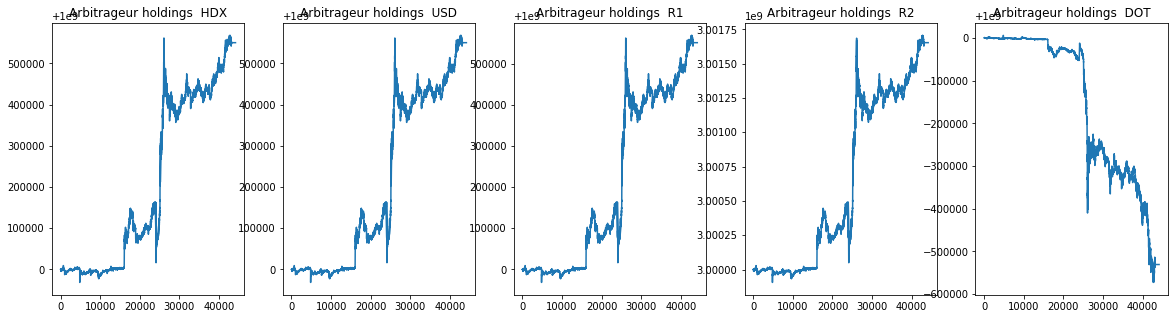

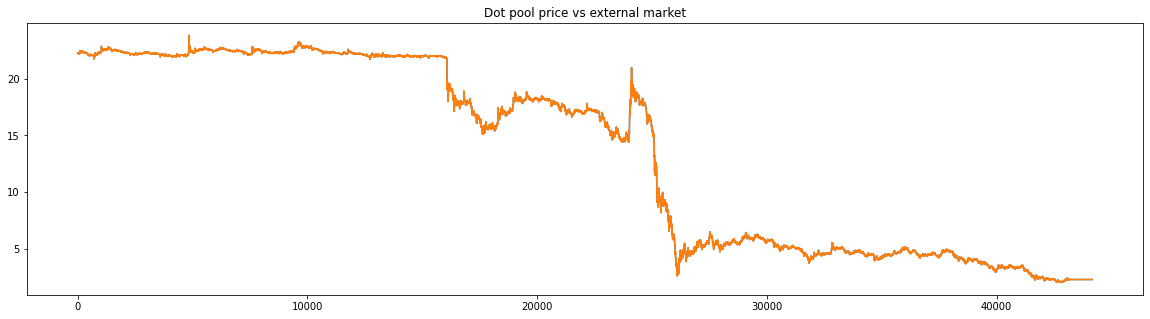

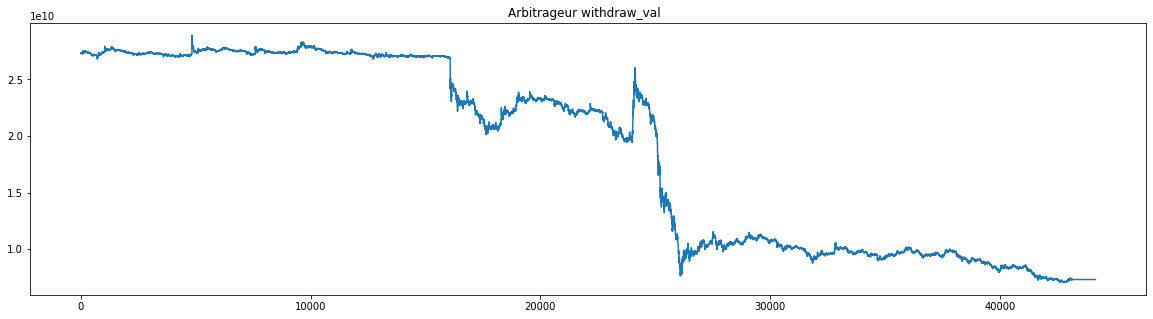

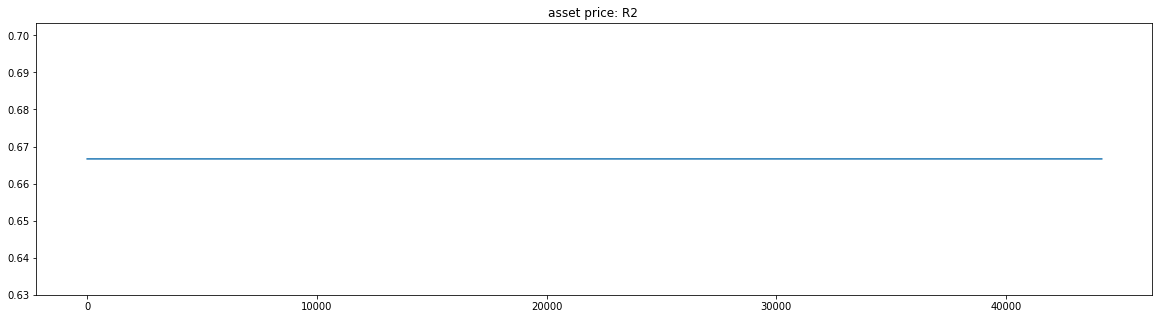

In [3]:
pu.plot(events, asset='all')
pu.plot(events, pool='omnipool', prop='liquidity')
lrna_price_in_usd = [event['state'].pools['omnipool'].liquidity['USD'] / event['state'].pools['omnipool'].lrna['USD'] for event in events]
DOT_pool_price_usd = [event['state'].pools['omnipool'].lrna['DOT'] * lrna_price_in_usd[i] / event['state'].pools['omnipool'].liquidity['DOT'] for i, event in enumerate(events)]
pu.plot(events, agent='Arbitrageur', prop='holdings', key=['HDX', 'USD', 'R1', 'R2', 'DOT'])
plt.figure(figsize=(20, 5))
plt.plot(range(2,time_steps), DOT_pool_price_usd[2::])
# plt.plot(range(100), DOT_pool_price_usd[0:100])
plt.plot(range(2,time_steps), pu.get_datastream(events, asset='DOT')[2::])
plt.title('Dot pool price vs external market')
# plt.plot(range(100), pu.get_datastream(events, asset='DOT')[0:100])
pu.plot(events, agent='Arbitrageur', prop='withdraw_val')
pu.plot(events, asset='R2')

In [4]:
from model.plot_utils import get_datastream

oracle_in = get_datastream(events=events, pool='omnipool', oracle='fee_raise', prop='volume_in', key='DOT')
oracle_out = get_datastream(events=events, pool='omnipool', oracle='fee_raise', prop='volume_out', key='DOT')
oracle_liq = get_datastream(events=events, pool='omnipool', oracle='fee_raise', prop='liquidity', key='DOT')
x = [(oracle_in[i] - oracle_out[i]) / oracle_liq[i] for i in range(len(oracle_in))]

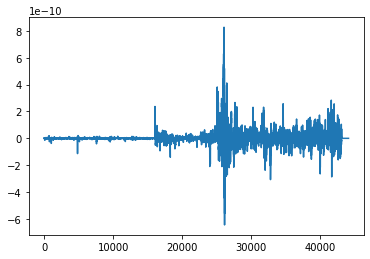

In [5]:
plt.plot(range(len(x)), x)

In [6]:
oracle_in = get_datastream(events=events, pool='omnipool', oracle='fee_lower', prop='volume_in', key='DOT')
oracle_out = get_datastream(events=events, pool='omnipool', oracle='fee_lower', prop='volume_out', key='DOT')
oracle_liq = get_datastream(events=events, pool='omnipool', oracle='fee_lower', prop='liquidity', key='DOT')
x = [(oracle_in[i] - oracle_out[i]) / oracle_liq[i] for i in range(len(oracle_in))]

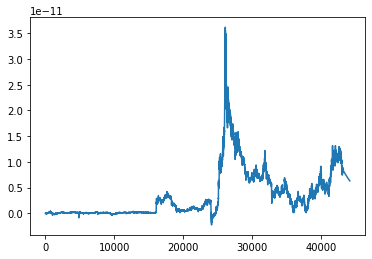

In [7]:
plt.plot(range(len(x)), x)


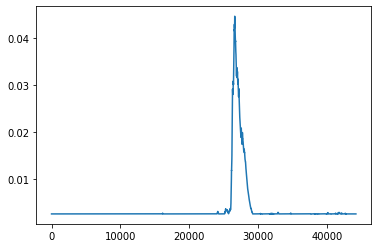

In [8]:
dynamic_fees = [events[i]['state'].pools['omnipool'].last_fee for i in range(len(events))]
plt.plot(range(len(dynamic_fees)), dynamic_fees)

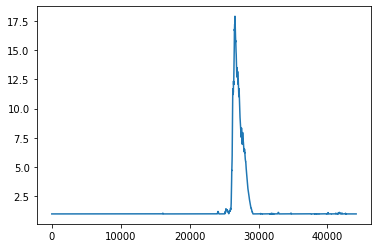

In [9]:
dynamic_mult = [events[i]['state'].pools['omnipool'].last_mult for i in range(len(events))]
plt.plot(range(len(dynamic_mult)), dynamic_mult)

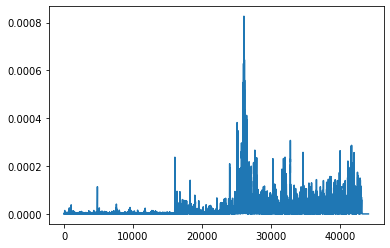

In [10]:
dynamic_temp = [events[i]['state'].pools['omnipool'].temp for i in range(len(events))]
plt.plot(range(len(dynamic_mult)), dynamic_temp)

In [11]:
pprint(dynamic_temp[0])

mpf('0.0')
